<a href="https://colab.research.google.com/github/timothychern/computer-graphics-kinematics/blob/master/Digit_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np

In [0]:
from mlxtend.data import loadlocal_mnist

In [0]:
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [0]:
use_cuda = True

In [6]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  36.7M      0 --:--:-- --:--:-- --:--:-- 36.7M


In [7]:
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   391k      0 --:--:-- --:--:-- --:--:--  391k


In [0]:
!gunzip t*-ubyte.gz

In [0]:
def load_data():
    
    X, y = loadlocal_mnist(
        images_path="train-images-idx3-ubyte", 
        labels_path="train-labels-idx1-ubyte")
    X = torch.from_numpy(X).float()/255.
    y = torch.ones(y.shape[0])
    return X, y

In [0]:
train_data, train_label = load_data()

In [0]:
train_data = torch.reshape(train_data ,[-1, 1, 28, 28])
train_label = torch.reshape(train_label ,[-1, 1])

In [0]:
class Discriminator(nn.Module):
    ### Layers    Shape
    ### --------- ------------------
    ### Input     (None, 28, 28, 1)
    ### Conv_1    (None, 14, 14, 32)
    ### leakyrelu (None, 14, 14, 32)
    ### dropout   (None, 14, 14, 32)
    ### flatten   (None, 6272)
    ### Dense     (None, 784)
    ### leakyrelu (None, 784)
    ### dropout   (None, 784)
    ### dense     (None, 1)
    ### sigmoid   (None, 1)
    
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers= nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(6272, 784),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(784, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

In [0]:
d = Discriminator()

In [24]:
d.cuda()

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Flatten()
    (4): Linear(in_features=6272, out_features=784, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=784, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [28]:
d(train_data)

tensor([[0.4579],
        [0.5049],
        [0.4903],
        ...,
        [0.4963],
        [0.4800],
        [0.4774]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [0]:
train_data = train_data.cuda()
train_label = train_label.cuda()

In [0]:
class Generator(nn.Module):
    ### Layers    Shape
    ### --------- ------------------
    ### Input     (None, 784)
    ### Dense     (None, 6272)
    ### LeakyRelu (None, 6272)
    ### dropout   (None, 6272)
    ### reshape   (None, 14, 14, 32)
    ### 2Dconv_T  (None, 28, 28, 32)
    ### leakrelu  (None, 28, 28, 32)
    ### dropout   (None, 28, 28, 32)
    ### 2Dconv_T  (None, 28, 28, 1)
    ### tanh      (None, 28, 28, 1)
    
    
    def __init__(self, input_length: int=784):
        super(Generator, self).__init__()
        self.layers_1D = nn.Sequential(
            nn.Linear(784, 6272),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.layers_2D = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layers_1D(x)
        x = torch.reshape(x ,[-1, 32, 14, 14])
        x = self.layers_2D(x)
        return 0.5*(x+1)

In [0]:
def train(batch_size: int=16, 
          noise_size: int=784,
          epoch: int=50,
          learning_rate: float=0.001,
          print_result_at: int=10):
    
    G = Generator(noise_size)
    D = Discriminator()
    
    if use_cuda and torch.cuda.is_available():
        G.cuda()
        D.cuda()

    optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate)
    
    loss = nn.BCELoss()
    
    for i in range(epoch):
        optimizer_G.zero_grad()
        noise = torch.normal(mean=0., std=1., size=(batch_size, noise_size)).cuda()
        generated_data = G(noise)
        
        generator_discriminator_out = D(generated_data)
        generator_loss = loss(generator_discriminator_out, torch.ones((batch_size,1)).cuda())
        generator_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        true_discriminator_out = D(train_data)
        true_discriminator_loss = loss(true_discriminator_out, train_label)
        
        generator_discriminator_out = D(generated_data.detach())
        generator_discrimator_loss = loss(generator_discriminator_out, torch.zeros((batch_size,1)).cuda())
        discriminator_loss = 0.5 * (true_discriminator_loss + generator_discrimator_loss)
        discriminator_loss.backward()
        optimizer_D.step()
        
        if i % print_result_at == 0:
            img = generated_data[0].reshape((28,28))
            plt.imshow(img.cpu().detach())
            plt.show()

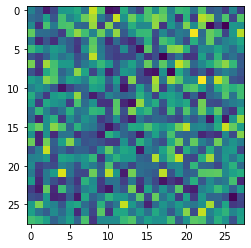

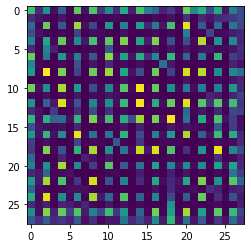

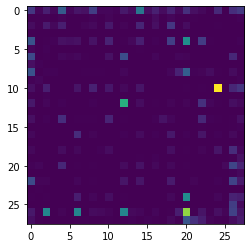

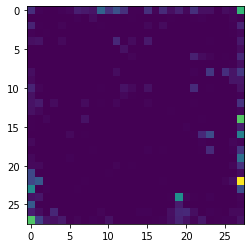

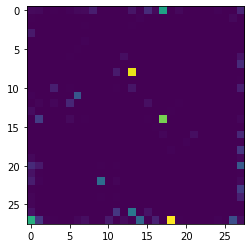

In [47]:
train(batch_size=100)

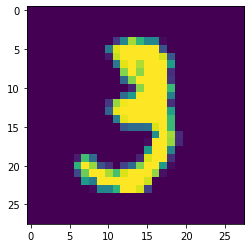

In [46]:
plt.imshow(train_data[10].reshape(28,28).cpu())